In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

data shape:  (1797, 64)
class shape:  (1797,)


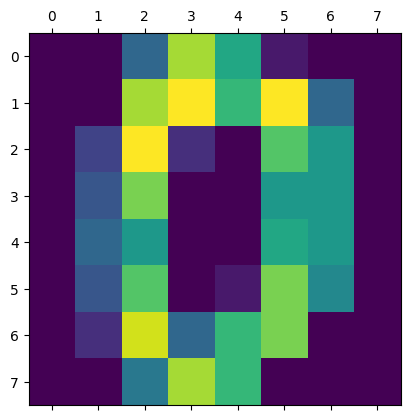

In [ ]:
# load the digits dataset
digits = load_digits()
x = digits.data
y = digits.target
n_samples, n_features = x.shape

print("data shape: ",x.shape)
print("class shape: ",y.shape)

N_train = int(0.8 * x.shape[0])
x_train = x[:N_train,:]
y_train = y[:N_train]
x_val = x[N_train:,:]
y_val = y[N_train:]

# Add the bias term
x_train = np.hstack((x_train, np.ones((x_train.shape[0], 1))))
x_val = np.hstack((x_val, np.ones((x_val.shape[0], 1))))
plt.matshow(digits.images[0])
plt.show()

In [ ]:
'''
Add code to transform the data into Pytorch tensors. Hint! The features (i.e. images) should be of type float and
labels of type long
'''
X_train = torch.from_numpy(x_train).float()# TODO: add code
Y_train = torch.from_numpy(y_train).long()# TODO: add code
X_val = torch.from_numpy(x_val).float()# TODO: add code
Y_val = torch.from_numpy(y_val).long()# TODO: add code
#don't forget the ()

In [ ]:
# create Dataset object to support batch training
class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        # TODO: load your features and the labels in this class
        self.features = features# TODO: add code
        self.labels = labels# TODO: add code

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

In [ ]:
class simpleMLP(nn.Module):
    # TODO: define model elements
    #create a neural network with two fully connected layers. You should use the Pytorch Linear module
    #Input and output of the network is straighforward and the hidden layer size is given by the parameter hidden_size.
    #In between the two Linear layers you should use a relu activation
    def __init__(self, n_inputs,n_classes,hidden_size):
        super(simpleMLP, self).__init__()
        self.fc1=nn.Linear(n_inputs, hidden_size)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden_size,n_classes)


    #TODO: forward propagate input
    def forward(self, x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

In [ ]:
class complexMLP(nn.Module):
    # TODO: define model elements
    def __init__(self, n_inputs,n_classes,hidden_size=None):
        super(complexMLP, self).__init__()
        hidden_size=100
        dropout=0.2

        # TODO: Add the first fully connected layer with 100 hidden units with batch norm, dropout of 0.2
        self.fc1=nn.Linear(n_inputs.hidden_size)
        self.bn1=nn.BatchNorm1d(hidden_size)
        self.dropoutfc1=nn.Dropout(dropout)

        hidden_size_2=32
        # TODO: Add the second fully connected layer with 32 hidden units with batch norm, dropout of 0.2
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.bn2=nn.BatchNorm1d(hidden_size_2)
        self.dropoutfc2 = nn.Dropout(dropout)

        self.output  = nn.Linear(hidden_size_2, n_classes)
        #TODO: project to the number of classes using a third fully connected layer


    # TODO: forward propagate input
    def forward(self, x):
        x = self.fc1(x)
        x=self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropoutfc1(x)

        x = self.fc2(x)
        x=self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropoutfc2(x)

        x=self.output(x)


        return x

In [ ]:
def get_predictions(model,data):
    #TODO: return the predictions of the model
    # Find the prediction (as the classes with highest values in the vector)
    predictions = model(data).numpy().argmax(axis=1)# TODO: add code
    return predictions
def compute_accuracy(predictions,ground_truth):
    #TODO: return the accuracy evaluation metric
    accuracy = (predictions==ground_truth.numpy()).mean() # TODO: add code
    return accuracy

In [ ]:
"""
In PyTorch, we could implement regularization pretty easily by adding a term to
the loss. After computing the loss, whatever the loss function is, we can iterate the
parameters of the model, sum their respective square (for L2) or abs (for L1), and
backpropagate.
Hint! You can find the parameters of the model in model.parameters()
"""
def l2_regularizer(model,l2_lambda):
    #TODO: This is for step 9: implement the l2 regularization
    l2_norm =sum(p.pow(2.0).sum() for p in model.parameters()) # TODO: add code
    return l2_lambda * l2_norm

def l1_regularizer(model,l1_lambda):
    #TODO: This is for step 9: implement the l2 regularization
    l1_norm = sum(p.abs().sum() for p in model.parameters()) # TODO: add code
    return l1_lambda * l1_norm

In [ ]:
def run_model(func,optimizer,learning_rate,num_epochs,hidden_size=None,regularization=None):

    # model = func(X_train.shape[1],len(list(set(Y_train.numpy()))),hidden_size) # TODO: add the required arguments
    model = func(x_train.shape[1],len(y_train),hidden_size)
    criterion = torch.nn.CrossEntropyLoss()# TODO: use the Cross Entropy Loss
    optimizer = optimizer(model.parameters(),lr=learning_rate)
    batch_size = 16

    # enable batching of training data
    train_dataset = Dataset(X_train, Y_train) #TODO: Fill in also the Dataset class above
    dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)#TODO: Use the Pytorch dataloader to enable batching of the data


    val_accs = np.zeros(num_epochs)

    for i_epoch in range(num_epochs):
        model.train()
        #TODO: enable the training mode in the model

        for i_batch, (X_batch, Y_batch) in enumerate(dataloader):
            model.zero_grad()
            # TODO: reset model gradients
            prediction = model(X_batch)# TODO: conduct a forward pass and get the scores for the classes
            loss = criterion(prediction,Y_batch)# TODO: compute the loss
            # TODO: for Step 9 add the regularization term to the loss
            if regularization =="l2":
                loss += l2_regularizer(model,0.001)#TODO: add code
            if regularization =="l1":
                loss += l1_regularizer(model,0.001)#TODO: add code
            # TODO: backpropogate loss to calculate gradients
            # TODO: update model weights
            loss.backward()
            optimizer.step()
        with torch.no_grad():  # no need to calculate gradients when assessing accuracy

            model.eval()
            #TODO: enable the evaluation mode in the model
            #TODO: fill in the following two functions
            pred_train = get_predictions(model,X_train) #get the predictions of your model on the training set
            train_acc = compute_accuracy(pred_train, Y_train) #calculate the accuracy of your model on the training set.
                                                              #This can used for debugging purposes (i.e., to see that
                                                              #your model can memorize the training set)

            print("Training accuracy: {}".format(train_acc))
            pred_val = get_predictions(model,X_val)        #get the predictions of your model on the val set
            val_acc = compute_accuracy(pred_val, Y_val)    #calculate the accuracy of your model on the val set.
            val_accs[i_epoch]=val_acc
            print("Validation accuracy: {}".format(val_acc))

    return val_accs

## Run the model

Training accuracy: 0.8058455114822547
Validation accuracy: 0.7472222222222222
Training accuracy: 0.9095337508698678
Validation accuracy: 0.8361111111111111
Training accuracy: 0.9262352122477383
Validation accuracy: 0.825
Training accuracy: 0.9589422407794015
Validation accuracy: 0.8638888888888889
Training accuracy: 0.9693806541405706
Validation accuracy: 0.8777777777777778
Training accuracy: 0.9672929714683368
Validation accuracy: 0.8805555555555555
Training accuracy: 0.9805149617258176
Validation accuracy: 0.8833333333333333
Training accuracy: 0.9791231732776617
Validation accuracy: 0.8805555555555555
Training accuracy: 0.9756437021572721
Validation accuracy: 0.8916666666666667
Training accuracy: 0.9839944328462074
Validation accuracy: 0.8861111111111111
Training accuracy: 0.9853862212943633
Validation accuracy: 0.8861111111111111
Training accuracy: 0.9937369519832986
Validation accuracy: 0.8972222222222223
Training accuracy: 0.9951287404314544
Validation accuracy: 0.9027777777777778

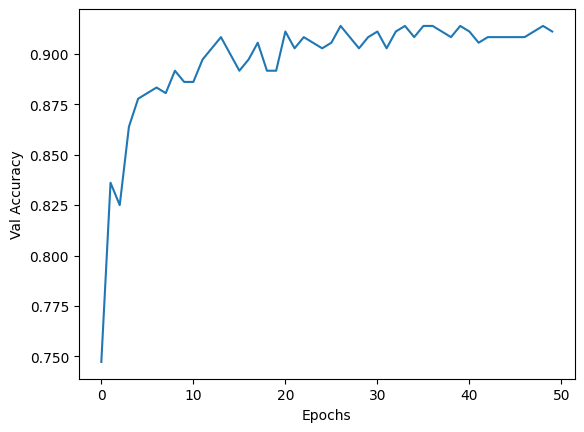

In [ ]:
#You will use Adam as an optimizer, a learning rate of 0.001, and a hidden size of 32. You will train the model for 50 epochs.
optimizer=torch.optim.Adam
val_acc=run_model(simpleMLP,optimizer,learning_rate=0.001,num_epochs=50,hidden_size=32)# TODO: add the required arguments
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

### Run the model with different learning rates

Training accuracy: 0.8928322894919972
Validation accuracy: 0.8222222222222222
Training accuracy: 0.9478079331941545
Validation accuracy: 0.8555555555555555
Training accuracy: 0.9784272790535838
Validation accuracy: 0.8888888888888888
Training accuracy: 0.9819067501739736
Validation accuracy: 0.9
Training accuracy: 0.9846903270702854
Validation accuracy: 0.9083333333333333
Training accuracy: 0.9784272790535838
Validation accuracy: 0.925
Training accuracy: 0.9860821155184412
Validation accuracy: 0.8805555555555555
Training accuracy: 0.9930410577592206
Validation accuracy: 0.8944444444444445
Training accuracy: 0.9846903270702854
Validation accuracy: 0.9111111111111111
Training accuracy: 0.9742519137091162
Validation accuracy: 0.8916666666666667
Training accuracy: 0.9930410577592206
Validation accuracy: 0.9055555555555556
Training accuracy: 0.9930410577592206
Validation accuracy: 0.8916666666666667
Training accuracy: 0.9972164231036882
Validation accuracy: 0.9111111111111111
Training accur

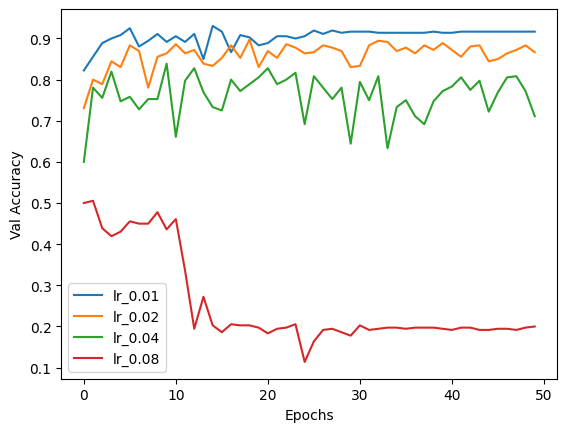

In [ ]:
optimizer=torch.optim.Adam
lrs=[0.01,0.02,0.04,0.08]# TODO: add the required values
fig = plt.subplot(111)
ax = plt.gca()
for lr in lrs:
    val_acc=run_model(simpleMLP,optimizer,learning_rate=lr,num_epochs=50,hidden_size=32)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(val_acc,color=color)


plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')

labels=[]
for lr in lrs:
    labels.append('lr_' + str(lr))

plt.legend(labels, loc = 'best')
plt.show()

### Run the model with different neural network hidden sizes

Training accuracy: 0.1544885177453027
Validation accuracy: 0.17222222222222222
Training accuracy: 0.3709116214335421
Validation accuracy: 0.3861111111111111
Training accuracy: 0.6450939457202505
Validation accuracy: 0.6638888888888889
Training accuracy: 0.7341684064022269
Validation accuracy: 0.7222222222222222
Training accuracy: 0.8329853862212944
Validation accuracy: 0.7944444444444444
Training accuracy: 0.8823938761308281
Validation accuracy: 0.8194444444444444
Training accuracy: 0.9081419624217119
Validation accuracy: 0.8305555555555556
Training accuracy: 0.9283228949199722
Validation accuracy: 0.8444444444444444
Training accuracy: 0.9352818371607515
Validation accuracy: 0.8555555555555555
Training accuracy: 0.9450243562978428
Validation accuracy: 0.8527777777777777
Training accuracy: 0.9491997216423104
Validation accuracy: 0.8583333333333333
Training accuracy: 0.9491997216423104
Validation accuracy: 0.8638888888888889
Training accuracy: 0.9561586638830898
Validation accuracy: 0.86

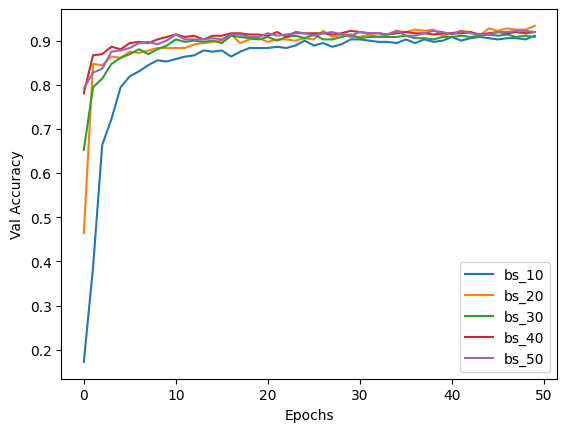

In [ ]:
optimizer=torch.optim.Adam
hss=[10,20,30,40,50]# TODO: add the required values
fig = plt.subplot(111)
ax = plt.gca()
for hs in hss:
    val_acc=run_model(simpleMLP,optimizer,learning_rate=0.001,num_epochs=50,hidden_size=hs)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(val_acc,color=color)

plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')

labels=[]
for hs in hss:
    labels.append('bs_' + str(hs))

plt.legend(labels, loc = 'best')
plt.show()

### Run the model with different optimizers

Training accuracy: 0.9359777313848295
Validation accuracy: 0.8166666666666667
Training accuracy: 0.9700765483646486
Validation accuracy: 0.8972222222222223
Training accuracy: 0.9902574808629089
Validation accuracy: 0.8916666666666667
Training accuracy: 0.9965205288796103
Validation accuracy: 0.9166666666666666
Training accuracy: 0.9979123173277662
Validation accuracy: 0.9222222222222223
Training accuracy: 0.9993041057759221
Validation accuracy: 0.9194444444444444
Training accuracy: 0.9986082115518441
Validation accuracy: 0.9083333333333333
Training accuracy: 1.0
Validation accuracy: 0.9305555555555556
Training accuracy: 1.0
Validation accuracy: 0.9305555555555556
Training accuracy: 0.9972164231036882
Validation accuracy: 0.9305555555555556
Training accuracy: 1.0
Validation accuracy: 0.9388888888888889
Training accuracy: 1.0
Validation accuracy: 0.9305555555555556
Training accuracy: 1.0
Validation accuracy: 0.9361111111111111
Training accuracy: 1.0
Validation accuracy: 0.936111111111111

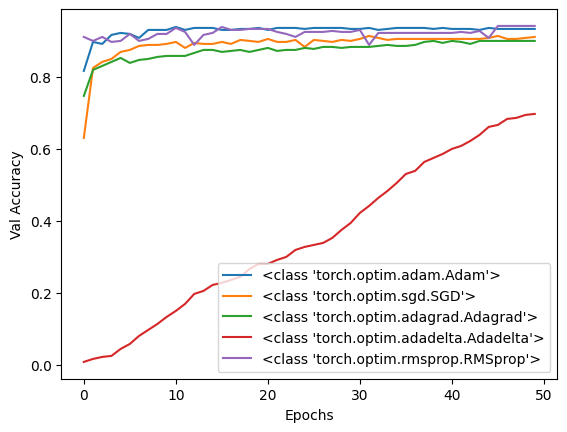

In [ ]:
optimizers=[torch.optim.Adam,torch.optim.SGD,torch.optim.Adagrad,torch.optim.Adadelta,torch.optim.RMSprop]
fig = plt.subplot(111)
ax = plt.gca()
for opt in optimizers:
    val_acc=run_model(simpleMLP,opt,learning_rate=0.001,num_epochs=50,hidden_size=256)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(val_acc,color=color)

plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')

labels=[]
for opt in optimizers:
    labels.append(str(opt))

plt.legend(labels, loc = 'best')
plt.show()

Training accuracy: 0.8448155880306193
Validation accuracy: 0.7777777777777778
Training accuracy: 0.9290187891440501
Validation accuracy: 0.8305555555555556
Training accuracy: 0.9610299234516354
Validation accuracy: 0.8472222222222222
Training accuracy: 0.9714683368128044
Validation accuracy: 0.8944444444444445
Training accuracy: 0.9784272790535838
Validation accuracy: 0.8888888888888888
Training accuracy: 0.9832985386221295
Validation accuracy: 0.9083333333333333
Training accuracy: 0.9839944328462074
Validation accuracy: 0.9111111111111111
Training accuracy: 0.988169798190675
Validation accuracy: 0.8861111111111111
Training accuracy: 0.9916492693110647
Validation accuracy: 0.9111111111111111
Training accuracy: 0.9923451635351427
Validation accuracy: 0.9083333333333333
Training accuracy: 0.988865692414753
Validation accuracy: 0.8944444444444445
Training accuracy: 0.9958246346555324
Validation accuracy: 0.9055555555555556
Training accuracy: 0.9958246346555324
Validation accuracy: 0.91388

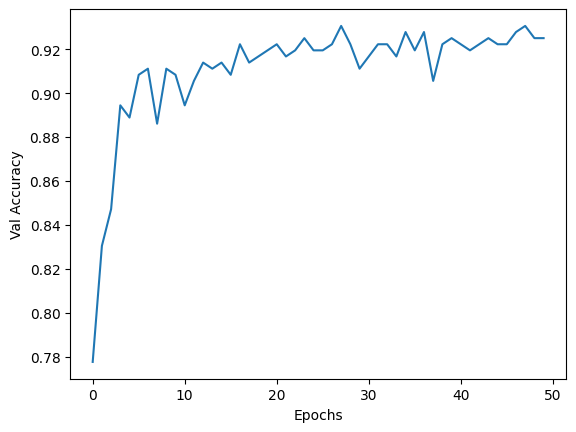

In [ ]:
#Step 9
val_acc=run_model(simpleMLP,optimizer,learning_rate=0.001,num_epochs=50,hidden_size=32,regularization="l2")
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

Training accuracy: 0.7473903966597077
Validation accuracy: 0.65
Training accuracy: 0.9269311064718163
Validation accuracy: 0.8277777777777777
Training accuracy: 0.9457202505219207
Validation accuracy: 0.8638888888888889
Training accuracy: 0.964509394572025
Validation accuracy: 0.8805555555555555
Training accuracy: 0.965205288796103
Validation accuracy: 0.8805555555555555
Training accuracy: 0.9721642310368824
Validation accuracy: 0.8833333333333333
Training accuracy: 0.9812108559498957
Validation accuracy: 0.8944444444444445
Training accuracy: 0.9839944328462074
Validation accuracy: 0.9111111111111111
Training accuracy: 0.9798190675017397
Validation accuracy: 0.9027777777777778
Training accuracy: 0.988169798190675
Validation accuracy: 0.8944444444444445
Training accuracy: 0.9895615866388309
Validation accuracy: 0.9
Training accuracy: 0.988169798190675
Validation accuracy: 0.8972222222222223
Training accuracy: 0.9923451635351427
Validation accuracy: 0.9111111111111111
Training accuracy: 

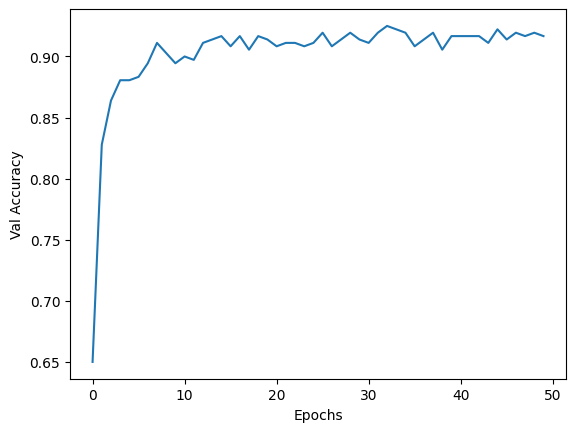

In [ ]:
#Step 9
val_acc=run_model(simpleMLP,optimizer,learning_rate=0.001,num_epochs=50,hidden_size=32,regularization="l1")
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

In [ ]:
#Step 10
val_acc=run_model(complexMLP,optimizer,learning_rate=0.001,num_epochs=50,hidden_size=None)
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

AttributeError: ignored